## Evolutionary Robotics

In this notebook, we will discuss evolutionary robotics and have you implement an evolutionary algorithm to solve one of the tasks in the AI gym, namely the continuous mountain car task. As you will see, an initial implementation of an evolutionary algorithm for solving a robotics task is easily made. However, obtaining good results may - depending on the task - be hard, and understanding the solution may even be harder still.

The figure below shows the typical evolutionary robotics approach. An initial population is randomly generated. Then there is an iterative process of: (1) Evaluating all individuals (genomes) in the population, resulting in a fitness value for each individual, (2) Selecting the individuals that will be allowed to procreate, i.e., form the new generation, and (3) Vary on the genomes of the selected individuals (using cross-over, mutation, etc.). The process typically terminates either after a specified number of generations, or after convergence to an optimal solution. Evaluation involves the conversion of the genome (genotype) to the phenotype (e.g., setting the weights of a neural network to the values in the genome). Then the phenotype is tested out on the task, typically in simulation but in some works also on real robots. In robotics tasks, evaluation is a stochastic process and execution of the task by the robot can take a long time. 

<img src="evolutionary_robotics_process.jpg" width="50%"></img>
*Figure 1:* Depiction of the typical evolutionary robotics approach. Figure from: _Doncieux, S., Bredeche, N., Mouret, J. B., & Eiben, A. E. G. (2015). Evolutionary robotics: what, why, and where to. Frontiers in Robotics and AI, 2, 4._


## MountainCarContinuous-v0

In this notebook, you will apply an evolutionary robotics approach to the continuous mountain car task. In this task, the car needs to reach the flag on the right mountain, while observing its position and velocity, and acting by means of accelerating the car left or right. The car cannot go straight up the mountain, but has to build up momentum to succeed. The fitness function rewards reaching the flag, and punishes the use of control actions (using less energy to reach the hill top is better). Please see the general description of the task <A HREF="https://gym.openai.com/envs/MountainCarContinuous-v0/" TARGET="_blank">here</A> and the details of the task <A HREF="https://github.com/openai/gym/wiki/MountainCarContinuous-v0" TARGET="_blank">here</A>. Most importantly, it has two observations, i.e., the position and velocity along the trajectory, and one control input, i.e., the applied force, which has to be in the interval $[-1, 1]$.

<img src="continuous_mountain_car.png" width="50%"></img>
*Figure 2:* Screenshot of the continuous mountain car task. 


Below you find code to evaluate an agent a single time in the mountain car environment. Please study the code, and note that the method ```act``` should be replaced in the end with a learned controller.

In [1]:
import run_cart
import gym
import numpy as np

class random_agent(object):
    """Random agent"""

    def act(self, observation, reward, done):
        return [2.0*np.random.rand()-1.0]

agent = random_agent()
reward = run_cart.run_cart_continuous(agent, graphics=False)
print('Reward = ' + str(reward))

Reward = -32.02383613546819


C:\Users\guido\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Using a continuous time recurrent neural network as controller

Of course, random control is not going to solve the task. Below, we introduce an agent that uses a continuous time recurrent neural network for control. This network was introduced by Randall Beer and used for one of the first times in the following article: Beer, Randall D. The dynamics of active categorical perception in an evolved model agent. Adaptive Behavior 11.4 (2003): 209-243.

CTRNNs are different from typical artificial neural networks (ANNs) in that they have an activation state $s$ which leads to a 'neural inertia'. Specifically, the activation formula, expressed as a differential equation, is:

\begin{equation}
\tau_i \dot{s_i} = -s_i + I_i + \sum_{j=1}^{N}{w_{j,i} \sigma (g_j(s_j + \theta_j))},
\end{equation}

where $\tau_i$ is the time constant of neuron $i$, $s_i$ its activation state, and $I_i$ its external inputs. $\sigma$ is the activation function, $g_j$ the gain of neuron $j$, and $\theta_j$ its bias. 

Below, we use <A HREF="https://github.com/madvn/CTRNN" TARGET="_blank">this CTRNN package</A>. It makes no explicit difference between types of neurons. So a network of size 10 means essentially a fully connected network of 10 neurons, where each neuron has connections to all other neurons and itself. In the code below, we give external inputs to the first two neurons, setting these inputs to the observations in the continuous mountain car task. We read out the last neuron as the output to be used for the car control. The activation function is $\sigma(s) = \frac{1}{1+e^{-s}}$.

<FONT COLOR="red">Exercise 1.</FONT>
1. Run the network multiple times. What values does it output over the different runs? Why?
2. Suppose that we want to start optimizing the weights and other parameters to have the car achieve the task. The ```act``` function below then has a fundamental problem. Can you spot what the problem is?


In [2]:
from CTRNN import CTRNN
from scipy.sparse import csr_matrix

class CTRNN_agent(object):
    
    """ Continuous Time Recurrent Neural Network agent. """
    
    n_observations = 2;
    n_actions = 1;
    
    def __init__(self, network_size, weights=[], taus = [], gains = [], biases = []):
        self.network_size = network_size;
        if(self.network_size < self.n_observations + self.n_actions):
            self.network_size = self.n_observations + self.n_actions;
        self.cns = CTRNN(self.network_size, step_size=0.1) 
        if(len(weights) > 0):
            # weights must be a matrix size: network_size x network_size
            self.cns.weights = csr_matrix(weights)
        if(len(biases) > 0):
            self.cns.biases = biases
        if(len(taus) > 0):
            self.cns.taus = taus
        if(len(gains) > 0):
            self.gains = gains
    
    def act(self, observation, reward, done):
        external_inputs = np.asarray([0.0]*self.network_size)
        external_inputs[0:self.n_observations] = observation
        self.cns.euler_step(external_inputs)
        return self.cns.outputs[-self.n_actions:]

# set up a CTRNN agent:
n_neurons = 10;
weights = np.zeros([n_neurons, n_neurons])
taus = np.asarray([0.1]*n_neurons)
gains = np.ones([n_neurons,])
biases = np.zeros([n_neurons,])
agent = CTRNN_agent(n_neurons, weights=weights, taus = taus, gains = gains, biases = biases)

# run the agent:
reward = run_cart.run_cart_continuous(agent, simulation_seed=0, graphics=False)

# print the reward:
print('Reward = ' + str(reward))

Reward = -24.99999999999965


## The simplest Evolutionary Algorithm for evolving a CTRNN

The code below shows a very simple evolutionary algorithm that optimizes all CTRNN parameters for the mountain car task.

Generation 0, mean = -60.6168401864164 max = -0.4820959119234966
Generation 1, mean = -21.343293800848688 max = -0.26861737758923365
Generation 2, mean = -27.176179656306473 max = -0.07588081630373772
Generation 3, mean = -24.041190271686848 max = -0.2889265870999758
Generation 4, mean = -14.246122913812746 max = -0.26671262192366424
Generation 5, mean = -15.372951923535977 max = -0.03559977406662322
Generation 6, mean = -15.700754299634985 max = -0.1361479633524653
Generation 7, mean = -14.473850859383639 max = -0.039735878206595396
Generation 8, mean = -16.96993179005137 max = -0.04964983018722762
Generation 9, mean = -13.51672992069415 max = -0.007558160144109944
Generation 10, mean = -22.003030961091863 max = -0.07810034141918051
Generation 11, mean = -19.725340630705084 max = -0.01129537876075554
Generation 12, mean = -19.14973178826292 max = -0.03778662046349285
Generation 13, mean = -15.47410910226405 max = -0.059024188485603424
Generation 14, mean = -17.405833089029212 max = -0

91.89145778673435

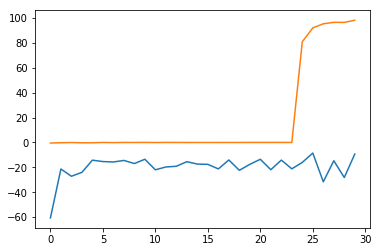

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from CTRNN import CTRNN
from scipy.sparse import csr_matrix
import run_cart
import gym
import numpy as np


# added unpacking of genome:
class CTRNN_agent(object):
    
    """ Continuous Time Recurrent Neural Network agent. """
    
    n_observations = 2;
    n_actions = 1;
    
    def __init__(self, network_size, genome = [], weights=[], taus = [], gains = [], biases = []):
        
        self.network_size = network_size;
        if(self.network_size < self.n_observations + self.n_actions):
            self.network_size = self.n_observations + self.n_actions;
        self.cns = CTRNN(self.network_size, step_size=0.1) 
        
        if(len(genome) == self.network_size*self.network_size+3*self.network_size):
            # Get the network parameters from the genome:
            weight_range = 3
            ind = self.network_size*self.network_size
            w = weight_range * (2.0 * (genome[:ind] - 0.5))
            weights = np.reshape(w, [self.network_size, self.network_size])
            biases = weight_range * (2.0 * (genome[ind:ind+self.network_size] - 0.5))
            ind += self.network_size
            taus = 0.9 * genome[ind:ind+self.network_size] + 0.05
            ind += self.network_size
            gains = 2.0 * (genome[ind:ind+self.network_size]-0.5)
        
        if(len(weights) > 0):
            # weights must be a matrix size: network_size x network_size
            self.cns.weights = csr_matrix(weights)
        if(len(biases) > 0):
            self.cns.biases = biases
        if(len(taus) > 0):
            self.cns.taus = taus
        if(len(gains) > 0):
            self.gains = gains
    
    def act(self, observation, reward, done):
        external_inputs = np.asarray([0.0]*self.network_size)
        external_inputs[0:self.n_observations] = observation
        self.cns.euler_step(external_inputs)
        output = 2.0 * (self.cns.outputs[-self.n_actions:] - 0.5)
        return output

def evaluate(genome, seed = 0, graphics = False):
    # create the phenotype from the genotype:
    agent = CTRNN_agent(n_neurons, genome=genome)
    # run the agent:
    reward = run_cart.run_cart_continuous(agent, simulation_seed=seed, graphics=graphics)
    #print('Reward = ' + str(reward))
    return reward
    
    
# Parameters CTRNN:
network_size = 10
genome_size = (network_size+3)*network_size

# Evolutionary algorithm:
n_individuals = 30
n_generations = 30
p_mut = 0.05
n_best = 3

Population = np.random.rand(n_individuals, genome_size)
Reward = np.zeros([n_individuals,])
max_fitness = np.zeros([n_generations,])
mean_fitness = np.zeros([n_generations,])
Best = []
fitness_best = []
for g in range(n_generations):
    
    # evaluate:
    for i in range(n_individuals):
        Reward[i] = evaluate(Population[i, :])
    mean_fitness[g] = np.mean(Reward)
    max_fitness[g] = np.max(Reward)
    print('Generation {}, mean = {} max = {}'.format(g, mean_fitness[g], max_fitness[g]))
    # select:
    inds = np.argsort(Reward)
    inds = inds[-n_best:]
    if(len(Best) == 0 or Reward[-1] > fitness_best):
        Best = Population[inds[-1], :]
        fitness_best = Reward[-1]
    # vary:
    NewPopulation = np.zeros([n_individuals, genome_size])
    for i in range(n_individuals):
        ind = inds[i % n_best]
        NewPopulation[i,:] = Population[ind, :]
        for gene in range(genome_size):
            if(np.random.rand() <= p_mut):
                NewPopulation[i,gene] = np.random.rand()
    Population = NewPopulation

print('Best fitness ' + str(fitness_best))
print('Genome = ' + str(Best))

plt.figure();
plt.plot(range(n_generations), mean_fitness)
plt.plot(range(n_generations), max_fitness)
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend(['Mean fitness', 'Max fitness'])

evaluate(Best, graphics=True)